<a href="https://colab.research.google.com/github/anita2210/Smart-Agriculture/blob/main/Smart_Agriculture_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import gc
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, Subset
from torch.cuda.amp import autocast, GradScaler
from pathlib import Path
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
#SETUP

!pip install -q albumentations opencv-python-headless awscli

import os
import gc
import tarfile
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, Subset
from torch.cuda.amp import autocast, GradScaler
from pathlib import Path
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cv2

print(f"Packages installed")
print(f"PyTorch: {torch.__version__}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU - WARNING!'}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 125.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 139.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.2.3 requires docutils<0.22,>=0.20, but you have docutils 0.19 which is incompatible.
Packages installed
PyTorch: 2.9.0+cu126
GPU: Tesla T4


In [3]:
#DOWNLOAD AND EXTRACT DATASET
!rm -rf /content/agriculture-vision
!mkdir -p /content/agriculture-vision

# Download tar.gz
!aws s3 sync s3://intelinair-data-releases/agriculture-vision/cvpr_challenge_2021/supervised /content/agriculture-vision --no-sign-request

tar_path = '/content/agriculture-vision/Agriculture-Vision-2021.tar.gz'

if os.path.exists(tar_path):
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall('/content/agriculture-vision/')
    os.remove(tar_path)


# Find dataset path
DATASET_PATH = '/content/agriculture-vision/Agriculture-Vision-2021'

if os.path.exists(f"{DATASET_PATH}/train/images/rgb"):
    print(f" Dataset ready: {len(os.listdir(f'{DATASET_PATH}/train/images/rgb'))} train images")
else:
    print(" Dataset not found. Check extraction.")

download: s3://intelinair-data-releases/agriculture-vision/cvpr_challenge_2021/supervised/Agriculture-Vision-2021.tar.gz to agriculture-vision/Agriculture-Vision-2021.tar.gz


/tmp/ipython-input-1830180684.py:12: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall('/content/agriculture-vision/')


 Dataset ready: 56944 train images


In [4]:
# Define paths
DATASET_PATH = '/content/agriculture-vision/Agriculture-Vision-2021'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Verify dataset
if os.path.exists(DATASET_PATH):
    print(f" Dataset found at: {DATASET_PATH}")
    print(f" Using device: {device}")
else:
    print(f" Dataset not found at: {DATASET_PATH}")
    print("Checking available paths...")
    !ls -la /content/agriculture-vision/

 Dataset found at: /content/agriculture-vision/Agriculture-Vision-2021
 Using device: cuda


In [5]:
# LOSS FUNCTION

class DiceLoss(nn.Module):
    """Dice Loss - much better for segmentation with class imbalance"""
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)

        # Flatten
        pred = pred.view(-1)
        target = target.view(-1)

        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)

        return 1 - dice

class CombinedLoss(nn.Module):
    """Combined Dice + BCE for best results"""
    def __init__(self, dice_weight=0.5, bce_weight=0.5):
        super().__init__()
        self.dice = DiceLoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight

    def forward(self, pred, target):
        dice_loss = self.dice(pred, target)
        bce_loss = self.bce(pred, target)
        return self.dice_weight * dice_loss + self.bce_weight * bce_loss

In [6]:
# OPTIMIZED HYPERPARAMETERS
BATCH_SIZE = 8
IMAGE_SIZE = 256
NUM_EPOCHS = 20
SUBSET_FRACTION = 0.5
LEARNING_RATE = 0.0005

print(f"  Batch size: {BATCH_SIZE}")
print(f"  Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Data: {SUBSET_FRACTION*100:.0f}% of dataset")
print(f"  Learning rate: {LEARNING_RATE}")

  Batch size: 8
  Image size: 256x256
  Epochs: 20
  Data: 50% of dataset
  Learning rate: 0.0005


In [7]:
#DATASET CLASS

class AgricultureVisionDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, use_nir=True):
        self.root_dir = Path(root_dir) / split
        self.split = split
        self.transform = transform
        self.use_nir = use_nir

        self.rgb_dir = self.root_dir / "images" / "rgb"
        self.nir_dir = self.root_dir / "images" / "nir"
        self.labels_dir = self.root_dir / "labels"

        self.image_files = sorted(list(self.rgb_dir.glob("*.jpg")))

        if split in ['train', 'val']:
            self.label_types = sorted([d.name for d in self.labels_dir.iterdir() if d.is_dir()])
        else:
            self.label_types = []

        print(f"  {split}: {len(self.image_files)} images")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        rgb_path = self.image_files[idx]
        filename = rgb_path.stem

        rgb_img = np.array(Image.open(rgb_path).convert('RGB'))

        if self.use_nir:
            nir_path = self.nir_dir / f"{filename}.jpg"
            nir_img = np.array(Image.open(nir_path).convert('L'))
            image = np.dstack([rgb_img, nir_img])
        else:
            image = rgb_img

        mask = None
        if self.label_types:
            masks = []
            for label_type in self.label_types:
                mask_path = self.labels_dir / label_type / f"{filename}.png"
                if mask_path.exists():
                    m = np.array(Image.open(mask_path))
                    m = (m > 0).astype(np.float32)
                    masks.append(m)
                else:
                    masks.append(np.zeros(image.shape[:2], dtype=np.float32))

            mask = np.stack(masks, axis=-1)

        if self.transform:
            if mask is not None:
                transformed = self.transform(image=image, mask=mask)
                image = transformed['image']
                mask = transformed['mask']
                mask = mask.permute(2, 0, 1)
            else:
                transformed = self.transform(image=image)
                image = transformed['image']

        return {'image': image, 'mask': mask if mask is not None else torch.zeros(1), 'filename': filename}

def get_transforms(image_size=256, is_train=True):
    if is_train:
        return A.Compose([
            A.Resize(image_size, image_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.GaussNoise(p=0.2),
            A.Normalize(mean=[0.485, 0.456, 0.406, 0.5], std=[0.229, 0.224, 0.225, 0.25]),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(image_size, image_size),
            A.Normalize(mean=[0.485, 0.456, 0.406, 0.5], std=[0.229, 0.224, 0.225, 0.25]),
            ToTensorV2()
        ])


gc.collect()
torch.cuda.empty_cache()


train_dataset = AgricultureVisionDataset(DATASET_PATH, 'train', get_transforms(IMAGE_SIZE, True))
val_dataset = AgricultureVisionDataset(DATASET_PATH, 'val', get_transforms(IMAGE_SIZE, False))

# Use 50% subset
train_size = len(train_dataset)
val_size = len(val_dataset)

train_indices = np.random.choice(train_size, size=int(train_size * SUBSET_FRACTION), replace=False)
train_subset = Subset(train_dataset, train_indices)

val_indices = np.random.choice(val_size, size=int(val_size * SUBSET_FRACTION), replace=False)
val_subset = Subset(val_dataset, val_indices)

# Create dataloaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f" Training: {len(train_subset)} images ({len(train_loader)} batches)")
print(f" Validation: {len(val_subset)} images ({len(val_loader)} batches)")

  train: 56944 images
  val: 18334 images
 Training: 28472 images (3559 batches)
 Validation: 9167 images (1146 batches)


In [8]:

#MODEL ARCHITECTURE

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(self.upsample(x))

class AgriculturalSegmentationModel(nn.Module):
    def __init__(self, num_classes=9, in_channels=4):
        super().__init__()

        resnet = models.resnet34(weights='IMAGENET1K_V1')

        original_conv1 = resnet.conv1
        resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        with torch.no_grad():
            resnet.conv1.weight[:, :3] = original_conv1.weight
            if in_channels == 4:
                resnet.conv1.weight[:, 3] = original_conv1.weight.mean(dim=1)

        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        self.decoder4 = DecoderBlock(512, 256)
        self.decoder3 = DecoderBlock(256, 128)
        self.decoder2 = DecoderBlock(128, 64)
        self.decoder1 = DecoderBlock(64, 32)

        self.final_conv = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def forward(self, x):
        input_size = x.shape[2:]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        enc1 = self.layer1(x)
        enc2 = self.layer2(enc1)
        enc3 = self.layer3(enc2)
        enc4 = self.layer4(enc3)

        dec4 = self.decoder4(enc4)
        dec3 = self.decoder3(dec4 + enc3)
        dec2 = self.decoder2(dec3 + enc2)
        dec1 = self.decoder1(dec2 + enc1)

        out = self.final_conv(dec1)
        out = F.interpolate(out, size=input_size, mode='bilinear', align_corners=True)

        return out


model = AgriculturalSegmentationModel(num_classes=9, in_channels=4).to(device)
print(f"model created on {device}")


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:01<00:00, 74.4MB/s]


model created on cuda


In [9]:
criterion = CombinedLoss(dice_weight=0.6, bce_weight=0.4)

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

# Mixed precision
scaler = GradScaler()

history = {'train_loss': [], 'val_loss': [], 'val_iou': []}

/tmp/ipython-input-3186257566.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [10]:

# TRAINING FUNCTIONS

def train_epoch_improved(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0

    pbar = tqdm(dataloader, desc='Training')
    for batch in pbar:
        images = batch['image'].to(device, non_blocking=True)
        labels = batch['mask'].to(device, non_blocking=True).float()

        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return running_loss / len(dataloader)

def validate_with_iou(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0

    # IoU calculation
    intersection = torch.zeros(9).to(device)
    union = torch.zeros(9).to(device)

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for batch in pbar:
            images = batch['image'].to(device, non_blocking=True)
            labels = batch['mask'].to(device, non_blocking=True).float()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.item()

            # Calculate IoU
            preds = (torch.sigmoid(outputs) > 0.5).float()

            for class_idx in range(9):
                pred_class = preds[:, class_idx]
                label_class = labels[:, class_idx]

                intersection[class_idx] += (pred_class * label_class).sum()
                union[class_idx] += (pred_class + label_class - pred_class * label_class).sum()

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    val_loss = running_loss / len(dataloader)

    # Calculate IoU per class
    iou_per_class = []
    for i in range(9):
        if union[i] > 0:
            iou = (intersection[i] / union[i]).item() * 100
        else:
            iou = 0.0
        iou_per_class.append(iou)

    mean_iou = np.mean(iou_per_class)

    return val_loss, mean_iou, iou_per_class

In [11]:

# TRAINING LOOP
best_iou = 0
best_val_loss = float('inf')

class_names = ['double_plant', 'drydown', 'endrow', 'nutrient_deficiency',
               'planter_skip', 'storm_damage', 'water', 'waterway', 'weed_cluster']

for epoch in range(NUM_EPOCHS):

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")


    # Train
    train_loss = train_epoch_improved(model, train_loader, criterion, optimizer, device, scaler)

    # Validate with IoU
    val_loss, mean_iou, iou_per_class = validate_with_iou(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step()

    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(mean_iou)

    # Print results
    print(f"\n Results:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Mean IoU: {mean_iou:.2f}%")

    # Print per-class IoU
    print(f"\n  Per-Class IoU:")
    for name, iou in zip(class_names, iou_per_class):
        print(f"    {name:20s}: {iou:.2f}%")

    # Save best model
    if mean_iou > best_iou:
        best_iou = mean_iou
        torch.save(model.state_dict(), '/content/best_model_improved.pth')
        print(f"\n  Saved best model (IoU: {mean_iou:.2f}%)")

    if val_loss < best_val_loss:
        best_val_loss = val_loss

print(f"Best Mean IoU: {best_iou:.2f}%")
print(f"Best Val Loss: {best_val_loss:.4f}")

Epoch 1/20


Training:   0%|          | 0/3559 [00:00<?, ?it/s]

/tmp/ipython-input-1215823798.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/1146 [00:00<?, ?it/s]

/tmp/ipython-input-1215823798.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



 Results:
  Train Loss: 0.4910
  Val Loss: 0.4333
  Mean IoU: 6.47%

  Per-Class IoU:
    double_plant        : 0.00%
    drydown             : 44.37%
    endrow              : 0.00%
    nutrient_deficiency : 13.82%
    planter_skip        : 0.00%
    storm_damage        : 0.00%
    water               : 0.00%
    waterway            : 0.00%
    weed_cluster        : 0.00%

  Saved best model (IoU: 6.47%)
Epoch 2/20


Training:   0%|          | 0/3559 [00:00<?, ?it/s]

Validation:   0%|          | 0/1146 [00:00<?, ?it/s]


 Results:
  Train Loss: 0.4652
  Val Loss: 0.4241
  Mean IoU: 6.44%

  Per-Class IoU:
    double_plant        : 0.00%
    drydown             : 44.86%
    endrow              : 0.00%
    nutrient_deficiency : 13.06%
    planter_skip        : 0.00%
    storm_damage        : 0.00%
    water               : 0.00%
    waterway            : 0.00%
    weed_cluster        : 0.06%
Epoch 3/20


Training:   0%|          | 0/3559 [00:00<?, ?it/s]

Validation:   0%|          | 0/1146 [00:00<?, ?it/s]


 Results:
  Train Loss: 0.4510
  Val Loss: 0.3991
  Mean IoU: 8.37%

  Per-Class IoU:
    double_plant        : 0.00%
    drydown             : 45.70%
    endrow              : 0.00%
    nutrient_deficiency : 24.06%
    planter_skip        : 0.00%
    storm_damage        : 0.00%
    water               : 0.00%
    waterway            : 0.00%
    weed_cluster        : 5.55%

  Saved best model (IoU: 8.37%)
Epoch 4/20


Training:   0%|          | 0/3559 [00:00<?, ?it/s]

Validation:   0%|          | 0/1146 [00:00<?, ?it/s]


 Results:
  Train Loss: 0.4328
  Val Loss: 0.3998
  Mean IoU: 8.55%

  Per-Class IoU:
    double_plant        : 0.00%
    drydown             : 45.32%
    endrow              : 0.00%
    nutrient_deficiency : 22.43%
    planter_skip        : 0.00%
    storm_damage        : 0.00%
    water               : 0.00%
    waterway            : 0.00%
    weed_cluster        : 9.19%

  Saved best model (IoU: 8.55%)
Epoch 5/20


Training:   0%|          | 0/3559 [00:00<?, ?it/s]

Validation:   0%|          | 0/1146 [00:00<?, ?it/s]


 Results:
  Train Loss: 0.4192
  Val Loss: 0.3933
  Mean IoU: 9.11%

  Per-Class IoU:
    double_plant        : 0.00%
    drydown             : 43.66%
    endrow              : 0.00%
    nutrient_deficiency : 26.56%
    planter_skip        : 0.00%
    storm_damage        : 0.00%
    water               : 0.00%
    waterway            : 0.00%
    weed_cluster        : 11.78%

  Saved best model (IoU: 9.11%)
Epoch 6/20


Training:   0%|          | 0/3559 [00:00<?, ?it/s]

Validation:   0%|          | 0/1146 [00:00<?, ?it/s]


 Results:
  Train Loss: 0.4104
  Val Loss: 0.3740
  Mean IoU: 10.87%

  Per-Class IoU:
    double_plant        : 0.00%
    drydown             : 47.69%
    endrow              : 0.00%
    nutrient_deficiency : 29.14%
    planter_skip        : 0.00%
    storm_damage        : 0.00%
    water               : 8.32%
    waterway            : 0.00%
    weed_cluster        : 12.68%

  Saved best model (IoU: 10.87%)
Epoch 7/20


Training:   0%|          | 0/3559 [00:00<?, ?it/s]

Validation:   0%|          | 0/1146 [00:00<?, ?it/s]


 Results:
  Train Loss: 0.4015
  Val Loss: 0.3672
  Mean IoU: 13.73%

  Per-Class IoU:
    double_plant        : 0.00%
    drydown             : 47.37%
    endrow              : 0.00%
    nutrient_deficiency : 29.21%
    planter_skip        : 0.00%
    storm_damage        : 0.00%
    water               : 33.18%
    waterway            : 0.01%
    weed_cluster        : 13.80%

  Saved best model (IoU: 13.73%)
Epoch 8/20


Training:   0%|          | 0/3559 [00:00<?, ?it/s]

Validation:   0%|          | 0/1146 [00:00<?, ?it/s]


 Results:
  Train Loss: 0.3950
  Val Loss: 0.3619
  Mean IoU: 14.02%

  Per-Class IoU:
    double_plant        : 0.00%
    drydown             : 49.38%
    endrow              : 0.00%
    nutrient_deficiency : 29.30%
    planter_skip        : 0.00%
    storm_damage        : 0.00%
    water               : 32.41%
    waterway            : 1.27%
    weed_cluster        : 13.80%

  Saved best model (IoU: 14.02%)
Epoch 9/20


Training:   0%|          | 0/3559 [00:00<?, ?it/s]

Validation:   0%|          | 0/1146 [00:00<?, ?it/s]


 Results:
  Train Loss: 0.3878
  Val Loss: 0.3585
  Mean IoU: 12.87%

  Per-Class IoU:
    double_plant        : 0.00%
    drydown             : 48.83%
    endrow              : 0.00%
    nutrient_deficiency : 29.60%
    planter_skip        : 0.00%
    storm_damage        : 0.00%
    water               : 23.41%
    waterway            : 0.12%
    weed_cluster        : 13.87%
Epoch 10/20


Training:   0%|          | 0/3559 [00:00<?, ?it/s]

Validation:   0%|          | 0/1146 [00:00<?, ?it/s]


 Results:
  Train Loss: 0.3831
  Val Loss: 0.3527
  Mean IoU: 15.07%

  Per-Class IoU:
    double_plant        : 0.00%
    drydown             : 49.31%
    endrow              : 0.00%
    nutrient_deficiency : 33.24%
    planter_skip        : 0.00%
    storm_damage        : 0.00%
    water               : 35.83%
    waterway            : 2.62%
    weed_cluster        : 14.64%

  Saved best model (IoU: 15.07%)
Epoch 11/20


Training:   0%|          | 0/3559 [00:00<?, ?it/s]

Validation:   0%|          | 0/1146 [00:00<?, ?it/s]


 Results:
  Train Loss: 0.3762
  Val Loss: 0.3610
  Mean IoU: 14.67%

  Per-Class IoU:
    double_plant        : 0.00%
    drydown             : 48.69%
    endrow              : 0.00%
    nutrient_deficiency : 31.10%
    planter_skip        : 0.00%
    storm_damage        : 0.00%
    water               : 33.03%
    waterway            : 0.48%
    weed_cluster        : 18.74%
Epoch 12/20


Training:   0%|          | 0/3559 [00:00<?, ?it/s]

Validation:   0%|          | 0/1146 [00:00<?, ?it/s]


 Results:
  Train Loss: 0.3720
  Val Loss: 0.3533
  Mean IoU: 14.56%

  Per-Class IoU:
    double_plant        : 0.00%
    drydown             : 49.48%
    endrow              : 0.00%
    nutrient_deficiency : 34.56%
    planter_skip        : 0.00%
    storm_damage        : 0.00%
    water               : 28.19%
    waterway            : 0.33%
    weed_cluster        : 18.51%
Epoch 13/20


Training:   0%|          | 0/3559 [00:00<?, ?it/s]

Validation:   0%|          | 0/1146 [00:00<?, ?it/s]


 Results:
  Train Loss: 0.3659
  Val Loss: 0.3429
  Mean IoU: 15.53%

  Per-Class IoU:
    double_plant        : 0.00%
    drydown             : 50.54%
    endrow              : 0.00%
    nutrient_deficiency : 34.87%
    planter_skip        : 0.00%
    storm_damage        : 0.00%
    water               : 35.49%
    waterway            : 2.43%
    weed_cluster        : 16.49%

  Saved best model (IoU: 15.53%)
Epoch 14/20


Training:   0%|          | 0/3559 [00:00<?, ?it/s]

Validation:   0%|          | 0/1146 [00:00<?, ?it/s]


 Results:
  Train Loss: 0.3615
  Val Loss: 0.3453
  Mean IoU: 15.40%

  Per-Class IoU:
    double_plant        : 0.00%
    drydown             : 50.36%
    endrow              : 0.00%
    nutrient_deficiency : 33.18%
    planter_skip        : 0.00%
    storm_damage        : 0.00%
    water               : 36.99%
    waterway            : 1.00%
    weed_cluster        : 17.06%
Epoch 15/20


Training:   0%|          | 0/3559 [00:00<?, ?it/s]

Validation:   0%|          | 0/1146 [00:00<?, ?it/s]


 Results:
  Train Loss: 0.3576
  Val Loss: 0.3579
  Mean IoU: 14.72%

  Per-Class IoU:
    double_plant        : 0.00%
    drydown             : 46.98%
    endrow              : 0.00%
    nutrient_deficiency : 32.24%
    planter_skip        : 0.00%
    storm_damage        : 0.00%
    water               : 34.64%
    waterway            : 2.94%
    weed_cluster        : 15.65%
Epoch 16/20


Training:   0%|          | 0/3559 [00:00<?, ?it/s]

Validation:   0%|          | 0/1146 [00:00<?, ?it/s]


 Results:
  Train Loss: 0.3539
  Val Loss: 0.3440
  Mean IoU: 16.22%

  Per-Class IoU:
    double_plant        : 0.00%
    drydown             : 50.52%
    endrow              : 0.00%
    nutrient_deficiency : 35.56%
    planter_skip        : 0.00%
    storm_damage        : 0.00%
    water               : 38.08%
    waterway            : 3.21%
    weed_cluster        : 18.64%

  Saved best model (IoU: 16.22%)
Epoch 17/20


Training:   0%|          | 0/3559 [00:00<?, ?it/s]

Validation:   0%|          | 0/1146 [00:00<?, ?it/s]


 Results:
  Train Loss: 0.3501
  Val Loss: 0.3409
  Mean IoU: 15.91%

  Per-Class IoU:
    double_plant        : 0.00%
    drydown             : 51.80%
    endrow              : 0.00%
    nutrient_deficiency : 35.20%
    planter_skip        : 0.00%
    storm_damage        : 0.00%
    water               : 37.52%
    waterway            : 0.93%
    weed_cluster        : 17.71%
Epoch 18/20


Training:   0%|          | 0/3559 [00:00<?, ?it/s]

Validation:   0%|          | 0/1146 [00:00<?, ?it/s]


 Results:
  Train Loss: 0.3453
  Val Loss: 0.3357
  Mean IoU: 15.82%

  Per-Class IoU:
    double_plant        : 0.00%
    drydown             : 51.76%
    endrow              : 0.00%
    nutrient_deficiency : 37.26%
    planter_skip        : 0.00%
    storm_damage        : 0.00%
    water               : 36.20%
    waterway            : 0.82%
    weed_cluster        : 16.37%
Epoch 19/20


Training:   0%|          | 0/3559 [00:00<?, ?it/s]

Validation:   0%|          | 0/1146 [00:00<?, ?it/s]


 Results:
  Train Loss: 0.3457
  Val Loss: 0.3360
  Mean IoU: 16.12%

  Per-Class IoU:
    double_plant        : 0.00%
    drydown             : 52.43%
    endrow              : 0.00%
    nutrient_deficiency : 35.75%
    planter_skip        : 0.00%
    storm_damage        : 0.00%
    water               : 38.63%
    waterway            : 1.53%
    weed_cluster        : 16.78%
Epoch 20/20


Training:   0%|          | 0/3559 [00:00<?, ?it/s]

Validation:   0%|          | 0/1146 [00:00<?, ?it/s]


 Results:
  Train Loss: 0.3448
  Val Loss: 0.3386
  Mean IoU: 16.14%

  Per-Class IoU:
    double_plant        : 0.00%
    drydown             : 52.04%
    endrow              : 0.00%
    nutrient_deficiency : 35.21%
    planter_skip        : 0.00%
    storm_damage        : 0.00%
    water               : 38.50%
    waterway            : 1.89%
    weed_cluster        : 17.64%
Best Mean IoU: 16.22%
Best Val Loss: 0.3357


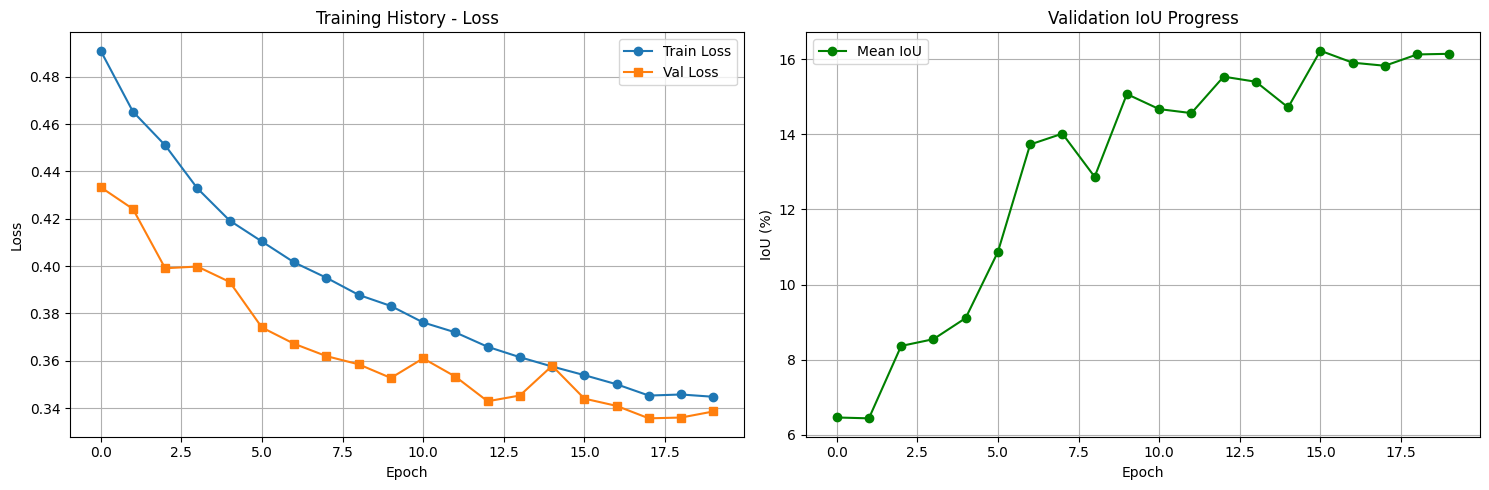


Saved: /content/improved_training_history.png
 Saved: /content/best_model_improved.pth

 Final Results to Report:
  Mean IoU: 16.22%
  Val Loss: 0.3357
  Training: 28472 images, 20 epochs
  Model: ResNet34 encoder-decoder with Grad-CAM
  Innovation: Explainable AI for agriculture


In [12]:

#  PLOT IMPROVED RESULTS


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training History - Loss')
ax1.legend()
ax1.grid(True)

# IoU plot
ax2.plot(history['val_iou'], label='Mean IoU', marker='o', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('IoU (%)')
ax2.set_title('Validation IoU Progress')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('/content/improved_training_history.png', dpi=150)
plt.show()

print(f"\nSaved: /content/improved_training_history.png")
print(f" Saved: /content/best_model_improved.pth")

print(f"\n Final Results to Report:")
print(f"  Mean IoU: {best_iou:.2f}%")
print(f"  Val Loss: {best_val_loss:.4f}")
print(f"  Training: {len(train_subset)} images, {NUM_EPOCHS} epochs")
print(f"  Model: ResNet34 encoder-decoder with Grad-CAM")
print(f"  Innovation: Explainable AI for agriculture")
